# Multi-frequency inversion with EMagPy

This notebook compared a mutli-coil instruments (CMD Explorer) and a multi-frequency instrument (GEM-2) synthetically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from emagpy import Problem

Forward modelling
Forward modelling


100%|██████████| 20/20 [00:32<00:00,  1.92s/it]


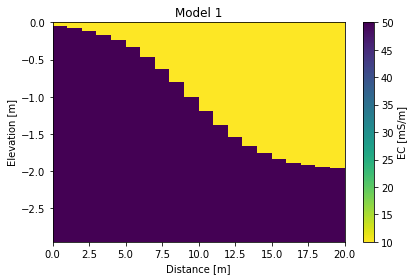

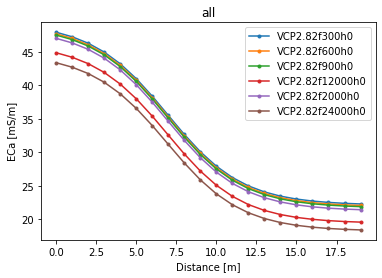

In [2]:
# parameters for the synthetic model
nlayer = 2 # number of layers
npos = 20 # number of positions/sampling locations
conds = np.ones((npos, nlayer))*[10, 50] # EC in mS/m
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1))) # depth of model

# defines coils configuration, frequency and height above the ground
coilsA = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
        'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coilsB = ['VCP2.82f300h0', 'VCP2.82f600h0', 'VCP2.82f900h0',
        'VCP2.82f12000h0', 'VCP2.82f2000h0', 'VCP2.82f24000h0']
coilsList = [coilsA, coilsB]

# foward modelling
ks = []
for i, coils in enumerate(coilsList):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSlin', coils=coils, noise=0.0)
    ks.append(k)
k.showResults() # display original model
k.show() # display ECa computed from forward modelling

for k, fm in zip(ks, ['FSlin']*len(coilsList)):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[20, 20], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 80), (0, 80)], rep=1000, njobs=-1)

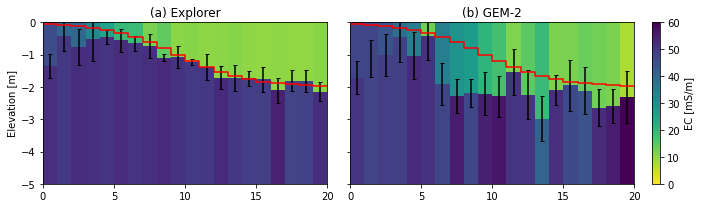

In [3]:
# figure
titles = ['(a) Explorer', '(b) GEM-2', '(c)', '(d)']
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=60, maxDepth=5, errorbar=True, dist=False)
    ax.step(-np.vstack([depths, depths[-1,:]]), 'r-', where='post')
    if i % 2 == 0:
        fig.axes[-1].remove() # remove colorbar
    else:
        ax.set_ylabel('')
    if i < 2:
        ax.set_xlabel('')
    ax.set_title(titles[i])
ax.set_xticks(np.arange(0, 21, 5))
fig.tight_layout()